In [7]:
import requests
from bs4 import BeautifulSoup
import time
import re
import csv

In [17]:
def parse_object_page(url, object_n, object_list, base_url):
    """
    Fonction pour parser une page contenant des informations sur un type d'objet.
    """
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Safari/537.3'}
    
    response = requests.get(url, headers=headers)

    if response.status_code == 200 :
        soup = BeautifulSoup(response.text, "html.parser")
        table = soup.find('table', class_='ak-table ak-responsivetable')
        if table:
            for row in table.find_all("tr")[1:]:
                recipe = []
                caracteristics = []
                effects = []
                time.sleep(1)
                
                name_element = row.find("td").find("a")
                name = name_element.text.strip()
                href = name_element['href']

                if object_n in ["equipements", "armes", "consommables"] :

                    recipe_url = base_url + href
                    recipe_response = requests.get(recipe_url, headers=headers)
                    recipe_soup = BeautifulSoup(recipe_response.text, "html.parser")
                    recipe_elements = recipe_soup.find_all(class_='ak-column ak-container col-xs-12 col-sm-6')

                    # Recipe elements
                    for element in recipe_elements:
                        span_elements = element.find_all('span', class_='ak-linker')
                        for span in span_elements:
                            text = span.text.strip()
                            if text != '':
                                recipe.append(text)
                    
                    # Properties elements
                    if object_n in ["equipements", "armes"] :
                        ak_contents  = recipe_soup.find_all("div", class_="col-sm-6")
                        for ak_content in ak_contents:
                            panel_titles = ak_content.find_all(class_="ak-panel-title")

                            if any("Caractéristiques" in panel_title.text for panel_title in panel_titles):
                                ak_titles = ak_content.find_all("div", class_="ak-title")
                                if ak_titles:
                                    for ak_title in ak_titles:
                                        text = ak_title.get_text(strip=True)
                                        caracteristics.append(text)
                            
                            if any("Effets" in panel_title.text for panel_title in panel_titles):
                                ak_titles = ak_content.find_all("div", class_="ak-title")
                                if ak_titles:
                                    for ak_title in ak_titles:
                                        text = ak_title.get_text(strip=True)
                                        effects.append(text)
                            
                            if any("Conditions" in panel_title.text for panel_title in panel_titles):
                                break

                name = row.find("td").find("img")['alt'].strip()
                type_ = row.find("td", class_="item-type").text.strip()
                level_str = row.find("td", class_="item-level").text.strip()
                level = int(re.search(r'\d+', level_str).group())

                object_info = {
                    "name": name,
                    "type": type_,
                    "level": level
                }

                if object_n in ["equipements", "armes", "consommables"] :
                    object_info["recipe"] = recipe
                    if object_n in ["equipements", "armes"] :
                        object_info["caracteristic"] = caracteristics
                        object_info["effect"] = effects

                object_list.append(object_info)
            return True  # Indique que la page a été analysée avec succès
    else:
        return False  # Indique qu'il y a eu une erreur lors de la requête

In [18]:
def counter_page(url, object_name) :
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Safari/537.3'}
    
    response = requests.get(url, headers=headers)

    while response.status_code != 200 :
        time.sleep(10)
        response = requests.get(url, headers=headers)

    # Parse the HTML
    soup = BeautifulSoup(response.text, "html.parser")

    # Find all <a> tags with href containing '/fr/mmorpg/encyclopedie/armes?page='
    url_object = f"/fr/mmorpg/encyclopedie/{object_name}\?page=\d+"
    links = soup.find_all('a', href=re.compile(url_object))

    # Extract numbers from the links
    numbers = [link.text.strip() for link in links if link.text.strip().isdigit()]
    last_pages = int(numbers[-1])
    return last_pages

In [19]:
def url_parser(base_url) :
    encyclopedia_url = base_url + "/fr/mmorpg/encyclopedie"

    objects = {
        "armes": [],
        "equipements": [],
        "consommables": [],
        "ressources": []
    }

    for object_name, object_list in objects.items():
        time.sleep(2)
        url = f"{encyclopedia_url}/{object_name}?page="
        nb_page = counter_page(url, object_name)
        for page in range(1, nb_page) :
            page_url = f"{url}{page}"
            success = parse_object_page(page_url, object_name, object_list, base_url)
            while success == False :
                time.sleep(10)
                success = parse_object_page(page_url, object_name, object_list, base_url)
        print(f"{len(object_list)} {object_name} find")
    
    return objects

In [21]:
base_url = "https://www.dofus-touch.com" # replace here to dofus in order to change the url
objects_touch = url_parser(base_url)

720 armes find
2040 equipements find
1248 consommables find
1824 ressources find


In [22]:
print(objects_touch["armes"][0])
print(objects_touch["equipements"][0])
print(objects_touch["consommables"][0])
print(objects_touch["ressources"][0])

{'name': 'Hache Ériphe', 'type': 'Hache', 'level': 200, 'recipe': ['Galet acajou', 'Etoffe de Cuirassé', 'Bec de Strigide', 'Œil de verre', 'Essence de Glourséleste', "Graisse d'Archillusion", 'Écharpe de Hanshi', "Bracelet d'Ino-Naru"], 'caracteristic': ['PA :5 (1 utilisation par tour)', 'Portée :1', 'CC :15% (+8)', 'Force > 349 etAgilité de base > 349'], 'effect': ['15 à 19 (dommages Neutre)', '21 à 27 (dommages Air)', '8 à 11 (vol Terre)', '201 à 250 Vitalité', '41 à 60 Force', '41 à 60 Agilité', '4 à 5% Coups Critiques', '1 PO', '-301 à 400 Initiative', '11 à 15 Prospection', '14 à 18 Dommages Neutre', '14 à 18 Dommages Terre', '14 à 18 Dommages Air', '7 à 10 % Résistance Neutre', '7 à 10 % Résistance Air', '7 à 10 Fuite', '16 à 20 Dommages Poussée']}
{'name': 'Coiffe du Comte Harebourg', 'type': 'Chapeau', 'level': 200, 'recipe': ['Galet acajou', 'Oeil de Harrogant', 'Cuir de Cuirboule', "Sang d'Armutin", 'Plume de Sinistro', 'Aile de Sinistrofu', 'Œil de verre', 'Essence de Comte

In [34]:
def save_object_list_to_csv(object_list, filename):
    """
    Create and save the object_list to a CSV file.
    """
    # Define the fieldnames based on the keys in the dictionaries in object_list
    fieldnames = object_list[0].keys()

    # Write object_list to a CSV file
    with open(filename, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        writer.writeheader()
        for obj in object_list:
            writer.writerow(obj)

def save_objects(objects) :
    # Assuming object_list is a dictionary where keys are object types and values are lists of objects
    for object_name, object_list in objects.items():

        filename = f"touch_{object_name}.csv"
        # Save the object list to the CSV file
        save_object_list_to_csv(object_list, filename)

save_objects(objects_touch)

In [35]:
import csv
import ast

def read_csv_file(filename):
    data = []  # List to store dictionaries for each row
    with open(filename, 'r', newline='', encoding='utf-8') as csvfile:
        reader = csv.DictReader(csvfile)  # Using DictReader to directly read rows into dictionaries
        for row in reader:
            # Convert the recipe string into a list
            try :
                row['recipe'] = ast.literal_eval(row['recipe'])
            except :
                pass

            for key, value in row.items():
                if isinstance(value, str):  # Check if the value is a string
                    row[key] = value.replace("'", " ")
                elif isinstance(value, list):  # Check if the value is a list
                    row[key] = [element.replace("'", " ") for element in value]
                    
            data.append(row)
    return data

In [36]:
objects_touch = {
    "armes": [],
    "equipements": [],
    "consommables": [],
    "ressources": []
}

for object_name, object_list in objects_touch.items():
    object_list.extend(read_csv_file(f"data/touch_{object_name}.csv"))

In [67]:
objects_pc = {
    "armes": [],
    "equipements": [],
    "consommables": [],
    "ressources": []
}

for object_name, object_list in objects_pc.items():
    object_list.extend(read_csv_file(f"data/pc_{object_name}.csv"))

In [98]:
import matplotlib.pyplot as plt

def calculate_occurrences(lst):
    occurrences = {}
    total_frequency = len(lst)
    for item in lst:
        occurrences[item] = occurrences.get(item, 0) + 1 / total_frequency
    return occurrences

def plot_occurrence_difference(occurrences1, occurrences2):
    differences = {}
    all_keys = set(occurrences1.keys()).union(occurrences2.keys())
    for key in all_keys:
        difference = (occurrences1.get(key, 0) - occurrences2.get(key, 0)) * 100
        differences[key] = difference
        
    # Plotting
    plt.figure(figsize=(16, 10))  # Augmenter la taille de la figure
    plt.bar(differences.keys(), differences.values())
    plt.xlabel('Niveaux')
    plt.ylabel('Fréquences (%)')
    plt.title('Différence des occurrences divisé par leur ratio respectif en fonction du niveaux')
    plt.xticks(rotation=45)
    plt.show()

In [99]:
def extract_lvl(str_item) :
    equipments_touch = objects_touch[str_item]
    equipments_pc = objects_pc[str_item]

    niveaux_equipment_touch = [equipement['level'] for equipement in equipments_touch]    
    niveaux_equipment_pc = [int(equipement['level']) for equipement in equipments_pc]

    return niveaux_equipment_touch, niveaux_equipment_pc

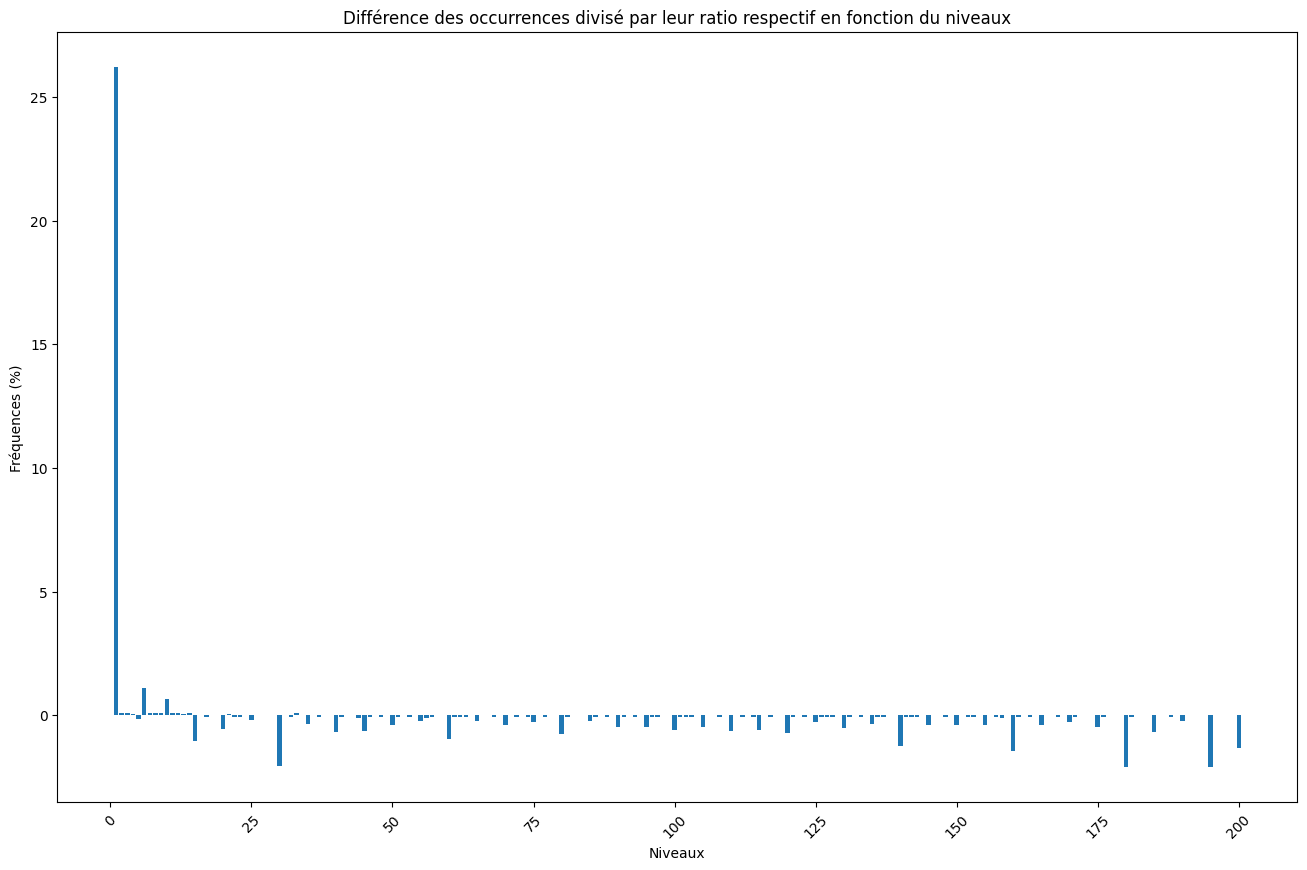

In [103]:
str_item = "consommables"
niveaux_equipment_touch, niveaux_equipment_pc = extract_lvl(str_item)

# Calculate occurrences for each list
occurrences_touch = calculate_occurrences(niveaux_equipment_touch)
occurrences_pc = calculate_occurrences(niveaux_equipment_pc)

# Plot the difference in occurrences
plot_occurrence_difference(occurrences_touch, occurrences_pc)